In [ ]:
import os
import numpy as np
import astropy.units as u
from astropy.modeling import models
from astropy.io import fits
from astropy.table import Table, vstack
import matplotlib.pyplot as plt
import paintbox as pb
from paintbox import utils
from ppxf import ppxf_util, miles_util

### Non-parametric models 

The SED of galaxies can be modeled as a superposition of templates, i.e., given a set of SED models *A*, an observed spectrum (or some parts of it) can described as an weighted sum of models in *A*. In this case, the problem of modeling the SED becomes to find an optimal set of weights. This method have been extensively explored by some tools such as [`ppxf`](https://pypi.org/project/ppxf/) and [`Starlight`](http://www.starlight.ufsc.br). For instance, in the modeling of emission lines, `ppxf` provides a simple tool to produce templates of the most important optical lines, as shown below.

Emission lines included in gas templates:
['Hdelta' 'Hgamma' 'Hbeta' 'Halpha' '[SII]6731_d1' '[SII]6731_d2'
 '[OIII]5007_d' '[OI]6300_d' '[NII]6583_d']


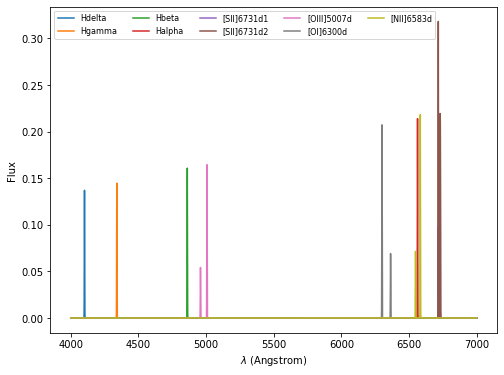

In [1]:
# Generating an wavelength array spaced logarithmically with
# fixed velocity scale
wrange = [4000, 7000]
velscale = 30 # Velocity shift between pixels
FWHM = 2.8 # Resolution of the observation

# Simple tool to get velocity dispersion with fixed velscale within a given range
wave = utils.disp2vel(wrange, velscale) 
logwave = np.log(wave)

gas_templates, gas_names, line_wave = ppxf_util.emission_lines(
        logwave, [wave[0], wave[-1]], FWHM,
        tie_balmer=False, limit_doublets=True)
gas_names = [_.replace("_", "") for _ in gas_names] # Removing underlines from names
fig = plt.figure(figsize=(8, 6))
for i in range(len(gas_names)):
    plt.plot(wave, gas_templates[:,i], label=gas_names[i])
plt.legend(ncol=5, prop={"size": 8})
plt.xlabel("$\lambda$ (Angstrom)")
plt.ylabel("Flux")
plt.show()

In `paintbox`, we can also use templates as those shown above using the `NonParametricModel` class. For instance, to use the emission line templates shown above, we just need to do the following: 

In [5]:
# Creating paintbox component
emission = pb.NonParametricModel(wave, gas_templates.T, gas_names)# Notice the transpose here!
print("Name of the templates: ", ", ".join(emission.parnames))

Name of the templates:  Hdelta, Hgamma, Hbeta, Halpha, [SII]6731d1, [SII]6731d2, [OIII]5007d, [OI]6300d, [NII]6583d


Now, the `emission` object above can be called to produce a linear combination of all templates by providing a set of weights, given in the order indicated by the `parnames`parameter, as indicated in the example below.

In [ ]:
# Generating some random flux for each emission line
theta = np.random.random(len(gas_names))
print("Random fluxes of emission lines: ")
print(*zip(emission.parnames, theta))
fig = plt.figure(figsize=(8, 6))
plt.plot(wave, emission(theta))
plt.xlabel("$\lambda$ (Angstrom)")
plt.ylabel("Flux")
plt.show()

In practice, this class can be used in different ways, including emission line modeling, sky and telluric removal / correction, and also with stellar population models. Moreover, `NonParametricModel` compononents can be combined with any SED components in `paintbox`, and they can be modified later to include, e.g., kinematics and dust attenuation. 